Imports

In [1]:
import pandas as pd
import numpy as np
import random
import scipy
import json
import nltk
import math
import re
import threading
import copy
import requests 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize.regexp import (WordPunctTokenizer,wordpunct_tokenize)

Links for the datasets

In [2]:
url_links = 'https://zrekoj.github.io/hybrid-recommender-system/dataset/links.csv'
url_movies = 'https://zrekoj.github.io/hybrid-recommender-system/dataset/movies.csv'
url_ratings = 'https://zrekoj.github.io/hybrid-recommender-system/dataset/ratings.csv'
url_tags = 'https://zrekoj.github.io/hybrid-recommender-system/dataset/tags.csv'
url_genres = 'https://zrekoj.github.io/hybrid-recommender-system/dataset/user_genre.json'

Datasets

In [3]:
ds_links = pd.read_csv(url_links, dtype = str)
ds_movies = pd.read_csv(url_movies, dtype = str)
ds_ratings = pd.read_csv(url_ratings)
ds_tags = pd.read_csv(url_tags, dtype = str)
ds_user_genres = pd.read_json(url_genres)

In [4]:
list_movies_id = list(ds_movies['movieId'].unique())
list_title_id = ds_movies['title'].tolist()
list_users_id = list(ds_ratings['userId'].unique())
list_movies_imdbid = ds_links['imdbId'].tolist()

Input ratings

In [5]:
'''
movie_ids=[]
ratings=[]

for i in range(10):
  index=random.randint(0,len(list_movies_id)-1)
  while list_movies_id[index] in movie_ids:
    index=random.randint(0,len(list_movies_id)-1)
  rating = float(input('Rate the movie '+str(list_title_id[index])+' from 0.5 to 5.0 or say 0.0 if you haven\'t seen it :'))
  movie_ids.append(list_movies_id[index])
  ratings.append(rating)
print(movie_ids)
print(ratings)
'''


"\nmovie_ids=[]\nratings=[]\n\nfor i in range(10):\n  index=random.randint(0,len(list_movies_id)-1)\n  while list_movies_id[index] in movie_ids:\n    index=random.randint(0,len(list_movies_id)-1)\n  rating = float(input('Rate the movie '+str(list_title_id[index])+' from 0.5 to 5.0 or say 0.0 if you haven't seen it :'))\n  movie_ids.append(list_movies_id[index])\n  ratings.append(rating)\nprint(movie_ids)\nprint(ratings)\n"

Collaborative filtering

SVD

In [6]:
def getGenresByUser(user_id, ds=ds_user_genres):
  return ds[user_id]['like'], ds[user_id]['dislike']

print(getGenresByUser(1))

(['Film-Noir', 'Animation', 'Musical', 'Children', 'Drama', 'War'], ['Comedy', 'Sci-Fi', 'Mystery', 'Thriller', 'Horror'])


In [7]:
#hyperparams

test_ratio = 0.2 #fraction of data to be used as test set.
no_of_features = [8,10,12,14,17,20] # to test the performance over a different number of features

In [14]:
ds_ratings['userId'] = ds_ratings['userId'].astype('str')
ds_ratings['movieId'] = ds_ratings['movieId'].astype('str')

users = ds_ratings['userId'].unique() #list of all users
movies = ds_ratings['movieId'].unique() #list of all movies

test = pd.DataFrame(columns=ds_ratings.columns)
train = pd.DataFrame(columns=ds_ratings.columns)

for u in users:
  temp = ds_ratings[ds_ratings['userId'] == u]
  n = len(temp)
  test_size = int(test_ratio*n)

  temp = temp.sort_values('timestamp').reset_index()
  temp.drop('index', axis=1, inplace=True)

  dummy_test = temp.loc[n-1-test_size :]
  dummy_train = temp.loc[: n-2-test_size]
    
  test = pd.concat([test, dummy_test])
  train = pd.concat([train, dummy_train])

In [15]:
from scipy.linalg import sqrtm

def create_user_item_matrix(data, formatizer = {'user':0, 'item': 1, 'value': 2}):
    itemField = formatizer['item']
    userField = formatizer['user']
    valueField = formatizer['value']

    
    userList = data.iloc[:,userField].tolist()
    itemList = data.iloc[:,itemField].tolist()
    valueList = data.iloc[:,valueField].tolist()

    users = list(set(data.iloc[:,userField]))
    items = list(set(data.iloc[:,itemField]))

    users_index = {users[i]: i for i in range(len(users))}

    pd_dict = {item: [np.nan for i in range(len(users))] for item in items}

    for i in range(0,len(data)):
      item = itemList[i]
      user = userList[i]
      value = valueList[i]

      pd_dict[item][users_index[user]] = value
    
    X = pd.DataFrame(pd_dict)
    X.index = users

    itemcols = list(X.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}

    # users_index gives us a mapping of user_id to index of user
    # items_index provides the same for items

    return X, users_index, items_index

In [16]:
def svd(train, k):
    utilMat = np.array(train)

    # the nan or unavailable entries are masked
    mask = np.isnan(utilMat)
    masked_arr = np.ma.masked_array(utilMat, mask)

    item_means = np.mean(masked_arr, axis=0)

    # nan entries will replaced by the average rating for each item
    utilMat = masked_arr.filled(item_means)
    x = np.tile(item_means, (utilMat.shape[0],1))

    # we remove the per item average from all entries.
    # the above mentioned nan entries will be essentially zero now
    utilMat = utilMat - x

    # The magic happens here. U and V are user and item features
    U, s, V=np.linalg.svd(utilMat, full_matrices=False)
    s=np.diag(s)

    # we take only the k most significant features
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]

    s_root=sqrtm(s)
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)
    UsV = UsV + x
    return UsV

In [17]:
def rmse(true, pred):
    x = true - pred
    return sum([xi*xi for xi in x])/len(x)

In [18]:
uiMat, users_index, items_index = create_user_item_matrix(train)

In [13]:
#svd evaluation
for f in no_of_features:
  svdout = svd(uiMat, k=f)
  pred = [] #to store the predicted ratings
  for _,row in test.iterrows():
    user = row['userId']
    item = row['movieId']
    u_index = users_index[user]
    
    if item in items_index:
      i_index = items_index[item]
      pred_rating = svdout[u_index, i_index]
    else:
      pred_rating = np.mean(svdout[u_index, :])
    pred.append(pred_rating)
  print(rmse(test['rating'], pred))

1.003787809237221
1.0036410576245889
1.0047280968304313
1.0053854409715484
1.0046710025637096
1.005656722964721


In [25]:
def filter(u_id, user_genres = ds_user_genres, item_genres = ds_movies["genres"]):
  u_likes = user_genres[u_id]["like"]
  u_detest = user_genres[u_id]["dislike"]

  useritemMat, users_index, items_index = create_user_item_matrix(ds_ratings)
  svdout = svd(useritemMat, k=12)
  user_pos = users_index[str(u_id)]
  result = []
  for i in range(len(svdout[user_pos])):

    if str(i) in items_index:
      i_id = items_index[str(i)]
      i_genre = item_genres[i_id].split(sep="|")

      checkDislike =  any(item in i_genre for item in u_detest)
      if checkDislike is False:
        new_rate = svdout[user_pos][i]

        checkLike =  any(item in i_genre for item in u_likes)
        if checkLike is True and new_rate < 5.0:
          new_rate = new_rate + new_rate * .3
          if new_rate > 5.0:
            new_rate = 5.0
        result.append([ds_movies['movieId'][i_id], ds_movies["title"][i_id], new_rate])
 
  return sorted(result, key=lambda item: item[2], reverse=True)[:20]



In [27]:
filter(1)

[['5611', 'Four Feathers, The (2002)', 5.0],
 ['102088', 'Grandmaster, The (Yi dai zong shi) (2013)', 5.0],
 ['2745', 'Mission, The (1986)', 5.0],
 ['4292', 'Norma Rae (1979)', 5.0],
 ['7056', 'Public Enemy, The (1931)', 5.0],
 ['1933', 'Life of Emile Zola, The (1937)', 5.0],
 ['159811', 'The Bremen Town Musicians (1969)', 5.0],
 ['172583', 'Investigation Held by Kolobki (1986)', 5.0],
 ['26176', 'Titicut Follies (1967)', 5.0],
 ['5965', 'Duellists, The (1977)', 5.0],
 ['6668', 'Road Home, The (Wo de fu qin mu qin) (1999)', 5.0],
 ['484', 'Lassie (1994)', 5.0],
 ['7820', 'Virgin Spring, The (Jungfrukällan) (1960)', 5.0],
 ['954', 'Mr. Smith Goes to Washington (1939)', 5.0],
 ['1170', 'Best of the Best 3: No Turning Back (1995)', 5.0],
 ['3011', "They Shoot Horses, Don't They? (1969)", 5.0],
 ['3089',
  'Bicycle Thieves (a.k.a. The Bicycle Thief) (a.k.a. The Bicycle Thieves) (Ladri di biciclette) (1948)',
  5.0],
 ['563', 'Germinal (1993)', 5.0],
 ['43376',
  'Sophie Scholl: The Final D

**Content-based**

In [17]:
def cosine_similarity(u, v):
    return np.dot(u, np.transpose(v)) / (np.linalg.norm(u) * np.linalg.norm(v))

Calculate TF-IDF

In [18]:
 def computeTFIDF(user_frequence_dict):
        copied = copy.deepcopy(user_frequence_dict)
        total_movies = len(copied)
        total_word_movies_count = {}

        for frequency in copied.values():
            for word in frequency:
                total_word_movies_count[word] = total_word_movies_count.get(word, 0) + 1

        for frequency in copied.values():
            total_words_count = len(frequency)
            for word in frequency:
                #                TF                                 IDF
                frequency[word] = (frequency[word] / total_words_count) * (math.log(1 + (total_movies / total_word_movies_count[word])))
        return copied

Content-Based application

In [19]:
def content_based(user_id, hybrid=True):

    movie_similarities=[]

    #Get imbdIds of user movies
    user_movies = list(
        map(
            lambda movie_id : str(ds_links.loc[ds_links['movieId'] == str(movie_id), 'imdbId'].values[0]), 
            ds_ratings.loc[ds_ratings['userId'] == str(user_id), 'movieId'].tolist()
        )
    )

    collaborative_filtering_result = filter(user_id)


    movies=[]

    #If we are using content-based as part of the hybrid filter, it uses the results of the collaborative filtering
    #Otherwise it uses all movies
    if(hybrid):
        movies = list(
            map(
                lambda result : ds_links.loc[ds_links['movieId'] == str(result[0]), 'imdbId'].values[0], 
                collaborative_filtering_result
            )
        )
    else:
        movies=[str(movie_id) for movie_id in list_movies_imdbid if movie_id not in user_movies]

    response = requests.get('https://zrekoj.github.io/hybrid-recommender-system/user_frequency/'+ str(user_id)+'.json') 
    user_frequence_dict = response.json()

    for movie in movies:
        MaxSim = 0

        movie_frequence_dict = requests.get('https://zrekoj.github.io/hybrid-recommender-system/frequency/'+ str(movie)+'.json').json() 
        user_frequence_dict[str(movie)] = movie_frequence_dict
        TFIDF = computeTFIDF(user_frequence_dict)
        user_frequence_dict.pop(str(movie), None)

        no_exist_string = "***###***"
        
        TFIDF_highest = TFIDF[str(movie)]
        for user_movie in user_movies:
            TFIDF_user =  TFIDF[str(user_movie)]
            
            TFIDF_highest_keys = TFIDF_highest.keys()
            TFIDF_user_keys = TFIDF_user.keys()
            
            coincidence = list(set(TFIDF_highest_keys) & set(TFIDF_user_keys))
            TFIDF_highest_values_diff = list(set(TFIDF_highest_keys) - set(TFIDF_user_keys))
            TFIDF_user_values_diff = list(set(TFIDF_user_keys) - set(TFIDF_highest_keys))
            
            TFIDF_highest_values = coincidence + TFIDF_highest_values_diff + ([no_exist_string] * len(TFIDF_user_values_diff))
            TFIDF_user_values = coincidence + ([no_exist_string] * len(TFIDF_highest_values_diff)) + TFIDF_user_values_diff
            
            TFIDF_highest_values = list(
                map(
                    lambda value : TFIDF_highest[value] if value != no_exist_string else 0,
                    TFIDF_highest_values
                )
            )
            
            TFIDF_user_values = list(
                map(
                    lambda value : TFIDF_user[value] if value != no_exist_string else 0,
                    TFIDF_user_values
                )
            )
            
            similarity = cosine_similarity(TFIDF_highest_values, TFIDF_user_values)        

            if(similarity > MaxSim):
                MaxSim = similarity
                
        movie_similarities.append([movie, MaxSim])
        

    return sorted(movie_similarities, key=lambda item: item[1], reverse=True)

print(content_based(1))

1094249 0.07950933188193429
0119577 0.03278998241794748
0146838 0.06455013019546887
0089385 0.05815471304629225
0304229 0.0855014873973386
0114007 0.055105358151090536
0114916 0.0595944109930006
0102798 0.17307629401493463
0041594 0.07057003329608129
0199129 0.12967858576323765
1510938 0.07786330345947903
0092545 0.07533071561265854
0244316 0.05788941191858764
0104779 0.05918078229511197
0294357 0.12049458341852526
0113824 0.125902194245651
0118819 0.08952145915043483
0112342 0.09077668893012354
0038499 0.06793468001299897
2381991 0.06856206481457755
[['0102798', 0.17307629401493463], ['0199129', 0.12967858576323765], ['0113824', 0.125902194245651], ['0294357', 0.12049458341852526], ['0112342', 0.09077668893012354], ['0118819', 0.08952145915043483], ['0304229', 0.0855014873973386], ['1094249', 0.07950933188193429], ['1510938', 0.07786330345947903], ['0092545', 0.07533071561265854], ['0041594', 0.07057003329608129], ['2381991', 0.06856206481457755], ['0038499', 0.06793468001299897], ['0

Fuzzy Expert

In [20]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

  userId movieId  rating  timestamp
0      1       1     4.0  964982703
1      1       3     4.0  964981247
2      1       6     4.0  964982224
3      1      47     5.0  964983815
4      1      50     5.0  964982931
0      4.0
1      4.0
2      4.0
3      5.0
4      5.0
      ... 
227    4.0
228    5.0
229    4.0
230    4.0
231    5.0
Name: rating, Length: 232, dtype: float64
4.366379310344827
232


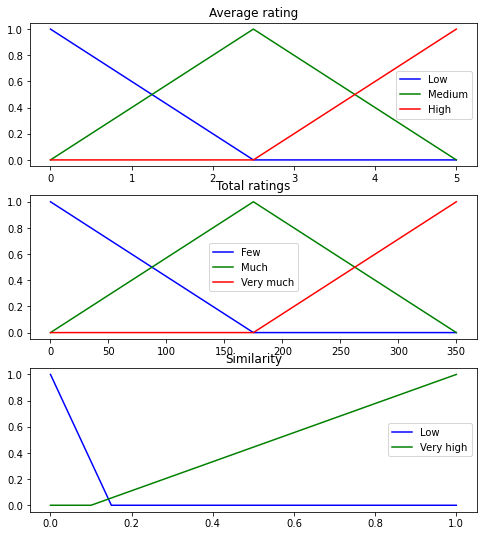

In [46]:
#Not normalized
user_id=1
print(ds_ratings.head())
user_ratings = ds_ratings[ds_ratings['userId']==str(user_id)]
average_rating=np.average(user_ratings['rating'])
total_rating=len(user_ratings['rating'])
content_based_result=[['0102798', 0.17307629401493463], ['0199129', 0.12967858576323765], ['0113824', 0.125902194245651], ['0294357', 0.12049458341852526], ['0112342', 0.09077668893012354], ['0118819', 0.08952145915043483], ['0304229', 0.0855014873973386], ['1094249', 0.07950933188193429], ['1510938', 0.07786330345947903], ['0092545', 0.07533071561265854], ['0041594', 0.07057003329608129], ['2381991', 0.06856206481457755], ['0038499', 0.06793468001299897], ['0146838', 0.06455013019546887], ['0114916', 0.0595944109930006], ['0104779', 0.05918078229511197], ['0089385', 0.05815471304629225], ['0244316', 0.05788941191858764], ['0114007', 0.055105358151090536], ['0119577', 0.03278998241794748]]
#content_based_result=content_based(user_id)
similarity=content_based_result[0][1]
print(user_ratings['rating'])
print(average)
print(total_rating)
#Generate variables
inp1 = np.arange(0, 5.5, 0.5)
inp2 = np.arange(0, 351, 1)
inp3 = np.arange(0, 1.05, 0.05)
importance = np.arange(0, 1.05, 0.05)

#Generate fuzzy membership functions
inp1_low = fuzz.trimf(inp1, [0, 0, 2.5])
inp1_medium = fuzz.trimf(inp1, [0, 2.5, 5])
inp1_high = fuzz.trimf(inp1, [2.5, 5, 5])
inp2_few = fuzz.trimf(inp2, [0, 0, 175])
inp2_much = fuzz.trimf(inp2, [0, 175, 350])
inp2_very_much = fuzz.trimf(inp2, [175, 350, 350])
inp3_low = fuzz.trimf(inp3, [0, 0, 0.15])
inp3_very_high = fuzz.trimf(inp3, [0.1, 1, 1])
importance_very_low = fuzz.trimf(importance, [0, 0, 0.25])
importance_low = fuzz.trimf(importance, [0, 0.25, 0.5])
importance_medium = fuzz.trimf(importance, [0.25, 0.5, 0.75])
importance_high = fuzz.trimf(importance, [0.5, 0.75, 1])
importance_very_high = fuzz.trimf(importance, [0, 1, 1])

#Visualize fuzzy membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))
ax0.plot(inp1, inp1_low, 'b', linewidth=1.5, label='Low')
ax0.plot(inp1, inp1_medium, 'g', linewidth=1.5, label='Medium')
ax0.plot(inp1, inp1_high, 'r', linewidth=1.5, label='High')
ax0.set_title('Average rating')
ax0.legend()

ax1.plot(inp2, inp2_few, 'b', linewidth=1.5, label='Few')
ax1.plot(inp2, inp2_much, 'g', linewidth=1.5, label='Much')
ax1.plot(inp2, inp2_very_much, 'r', linewidth=1.5, label='Very much')
ax1.set_title('Total ratings')
ax1.legend()

ax2.plot(inp3, inp3_low, 'b', linewidth=1.5, label='Low')
ax2.plot(inp3, inp3_very_high, 'g', linewidth=1.5, label='Very high')
ax2.set_title('Similarity')
ax2.legend()


  userId movieId  rating  timestamp
0      1       1     4.0  964982703
1      1       3     4.0  964981247
2      1       6     4.0  964982224
3      1      47     5.0  964983815
4      1      50     5.0  964982931
1094249 0.07950933188193429
0119577 0.03278998241794748
0146838 0.06455013019546887
0089385 0.05815471304629225
0304229 0.0855014873973386
0114007 0.055105358151090536
0114916 0.0595944109930006
0102798 0.17307629401493463
0041594 0.07057003329608129
0199129 0.12967858576323765
1510938 0.07786330345947903
0092545 0.07533071561265854
0244316 0.05788941191858764
0104779 0.05918078229511197
0294357 0.12049458341852526
0113824 0.125902194245651
0118819 0.08952145915043483
0112342 0.09077668893012354
0038499 0.06793468001299897
2381991 0.06856206481457755
0      4.0
1      4.0
2      4.0
3      5.0
4      5.0
      ... 
227    4.0
228    5.0
229    4.0
230    4.0
231    5.0
Name: rating, Length: 232, dtype: float64
0.8732758620689655
0.6628571428571428


Text(0.5, 1.0, 'Aggregated membership and result (line)')

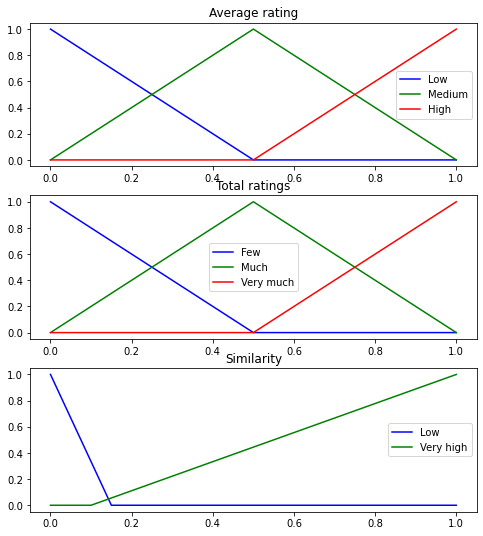

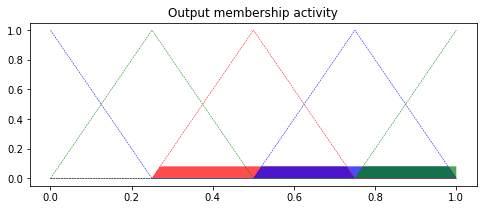

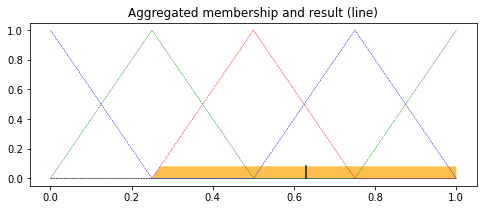

In [47]:
#Normalized
user_id=1
print(ds_ratings.head())
user_ratings = ds_ratings[ds_ratings['userId']==str(user_id)]
average_rating=np.average(user_ratings['rating'])/5
total_rating=len(user_ratings['rating'])/350
content_based_result=content_based(user_id)
similarity=content_based_result[0][1]
print(user_ratings['rating'])
print(average_rating)
print(total_rating)
#Generate variables
inp1 = np.arange(0, 1.01, 0.01)
inp2 = np.arange(0, 1.01, 0.01)
inp3 = np.arange(0, 1.01, 0.01)
importance = np.arange(0, 1.01, 0.01)

#Generate fuzzy membership functions
inp1_low = fuzz.trimf(inp1, [0, 0, 0.5])
inp1_medium = fuzz.trimf(inp1, [0, 0.5, 1])
inp1_high = fuzz.trimf(inp1, [0.5, 1, 1])
inp2_few = fuzz.trimf(inp2, [0, 0, 0.3])
inp2_medium = fuzz.trimf(inp2, [0.2, 0.4, 0.5])
inp2_much = fuzz.trimf(inp2, [0, 0.5, 1])
inp2_very_much = fuzz.trimf(inp2, [0.5, 1, 1])
inp3_very_low = fuzz.trimf(inp3, [0, 0, 0.06])
inp3_low = fuzz.trimf(inp3, [0.05, 0.06, 0.07])
inp3_medium = fuzz.trimf(inp3, [0.06, 0.07, 0.08])
inp3_high = fuzz.trimf(inp3, [0.07, 0.1, 0.13])
inp3_very_high = fuzz.trimf(inp3, [0.1, 1, 1])
                            
importance_very_low = fuzz.trimf(inp1, [0, 0, 0.25])
importance_low = fuzz.trimf(inp1, [0, 0.25, 0.5])
importance_medium = fuzz.trimf(inp1, [0.25, 0.5, 0.75])
importance_high = fuzz.trimf(inp1, [0.5, 0.75, 1])
importance_very_high = fuzz.trimf(inp1, [0.75, 1, 1])

#Visualize fuzzy membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))
ax0.plot(inp1, inp1_low, 'b', linewidth=1.5, label='Low')
ax0.plot(inp1, inp1_medium, 'g', linewidth=1.5, label='Medium')
ax0.plot(inp1, inp1_high, 'r', linewidth=1.5, label='High')
ax0.set_title('Average rating')
ax0.legend()

ax1.plot(inp2, inp2_few, 'b', linewidth=1.5, label='Few')
ax1.plot(inp2, inp2_much, 'g', linewidth=1.5, label='Much')
ax1.plot(inp2, inp2_very_much, 'r', linewidth=1.5, label='Very much')
ax1.set_title('Total ratings')
ax1.legend()

ax2.plot(inp3, inp3_low, 'b', linewidth=1.5, label='Low')
ax2.plot(inp3, inp3_very_high, 'g', linewidth=1.5, label='Very high')
ax2.set_title('Similarity')
ax2.legend()


#Apply rules
inp1_lo = fuzz.interp_membership(inp1, inp1_low, average_rating)
inp1_md = fuzz.interp_membership(inp1, inp1_medium, average_rating)
inp1_hi = fuzz.interp_membership(inp1, inp1_high, average_rating)
inp2_fe = fuzz.interp_membership(inp2, inp2_few, total_rating)
inp2_md = fuzz.interp_membership(inp2, inp2_medium, total_rating)
inp2_mu = fuzz.interp_membership(inp2, inp2_much, total_rating)
inp2_vm = fuzz.interp_membership(inp2, inp2_very_much, total_rating)
inp3_vl = fuzz.interp_membership(inp3, inp3_very_low, similarity)
inp3_lo = fuzz.interp_membership(inp3, inp3_low, similarity)
inp3_md = fuzz.interp_membership(inp3, inp3_medium, similarity)
inp3_hi = fuzz.interp_membership(inp3, inp3_high, similarity)
inp3_vh = fuzz.interp_membership(inp3, inp3_very_high, similarity)

inp1_low_and_inp2_few = np.fmin(inp1_lo, inp2_fe)
inp1_low_and_inp2_medium = np.fmin(inp1_lo, inp2_md)
inp1_low_and_inp2_much = np.fmin(inp1_lo, inp2_mu)
inp1_low_and_inp2_very_much = np.fmin(inp1_lo, inp2_vm)

inp1_medium_and_inp2_few = np.fmin(inp1_md, inp2_fe)
inp1_medium_and_inp2_medium = np.fmin(inp1_md, inp2_md)
inp1_medium_and_inp2_much = np.fmin(inp1_md, inp2_mu)
inp1_medium_and_inp2_very_much = np.fmin(inp1_md, inp2_vm)

inp1_high_and_inp3_low = np.fmin(inp1_hi, inp3_lo)
inp1_high_and_inp3_med = np.fmin(inp1_hi, inp3_md)
inp1_high_and_inp3_high = np.fmin(inp1_hi, inp3_hi)
inp1_high_and_inp3_very_high = np.fmin(inp1_hi, inp3_vh)

rule_001_005_009 = np.fmin(inp1_low_and_inp2_few, inp3_lo)
rule_002_006_010 = np.fmin(inp1_low_and_inp2_few, inp3_md)
rule_003_007_011 = np.fmin(inp1_low_and_inp2_few, inp3_hi)
rule_004_008_012 = np.fmin(inp1_low_and_inp2_few, inp3_vh)

rule_013_017_021 = np.fmin(inp1_low_and_inp2_medium, inp3_lo)
rule_014_018_022 = np.fmin(inp1_low_and_inp2_medium, inp3_md)
rule_015_019_023 = np.fmin(inp1_low_and_inp2_medium, inp3_hi)
rule_016_020_024 = np.fmin(inp1_low_and_inp2_medium, inp3_vh)

rule_025_029_033 = np.fmin(inp1_low_and_inp2_much, inp3_lo)
rule_026_030_034 = np.fmin(inp1_low_and_inp2_much, inp3_md)
rule_027_031_035 = np.fmin(inp1_low_and_inp2_much, inp3_hi)
rule_028_032_036 = np.fmin(inp1_low_and_inp2_much, inp3_vh)

rule_037_041_045 = np.fmin(inp1_low_and_inp2_very_much, inp3_lo)
rule_038_042_046 = np.fmin(inp1_low_and_inp2_very_much, inp3_md)
rule_039_043_047 = np.fmin(inp1_low_and_inp2_very_much, inp3_hi)
rule_040_044_048 = np.fmin(inp1_low_and_inp2_very_much, inp3_vh)

rule_049_053_057 = np.fmin(inp1_medium_and_inp2_few, inp3_lo)
rule_050_054_058 = np.fmin(inp1_medium_and_inp2_few, inp3_md)
rule_051_055_059 = np.fmin(inp1_medium_and_inp2_few, inp3_hi)
rule_052_056_060 = np.fmin(inp1_medium_and_inp2_few, inp3_vh)

rule_061_065_069 = np.fmin(inp1_medium_and_inp2_medium, inp3_lo)
rule_062_066_070 = np.fmin(inp1_medium_and_inp2_medium, inp3_md)
rule_063_067_071 = np.fmin(inp1_medium_and_inp2_medium, inp3_hi)
rule_064_068_072 = np.fmin(inp1_medium_and_inp2_medium, inp3_vh)

rule_073_077_081 = np.fmin(inp1_medium_and_inp2_much, inp3_lo)
rule_074_078_082 = np.fmin(inp1_medium_and_inp2_much, inp3_md)
rule_075_079_083 = np.fmin(inp1_medium_and_inp2_much, inp3_hi)
rule_076_080_084 = np.fmin(inp1_medium_and_inp2_much, inp3_vh)

rule_085_089_093 = np.fmin(inp1_medium_and_inp2_very_much, inp3_lo)
rule_086_090_094 = np.fmin(inp1_medium_and_inp2_very_much, inp3_md)
rule_087_091_095 = np.fmin(inp1_medium_and_inp2_very_much, inp3_hi)
rule_088_092_096 = np.fmin(inp1_medium_and_inp2_very_much, inp3_vh)

rule_097_101_105 = np.fmin(inp1_high_and_inp3_low, inp2_fe)
rule_098_102_106 = np.fmin(inp1_high_and_inp3_med, inp2_fe)
rule_099_103_107 = np.fmin(inp1_high_and_inp3_high, inp2_fe)
rule_100_104_108 = np.fmin(inp1_high_and_inp3_very_high, inp2_fe)

rule_109_113_117 = np.fmin(inp1_high_and_inp3_low, inp2_md)
rule_110_114_118 = np.fmin(inp1_high_and_inp3_med, inp2_md)
rule_111_115_119 = np.fmin(inp1_high_and_inp3_high, inp2_md)
rule_112_116_120 = np.fmin(inp1_high_and_inp3_very_high, inp2_md)

rule_121_125_129 = np.fmin(inp1_high_and_inp3_low, inp2_mu)
rule_122_126_130 = np.fmin(inp1_high_and_inp3_med, inp2_mu)
rule_123_127_131 = np.fmin(inp1_high_and_inp3_high, inp2_mu)
rule_124_128_132 = np.fmin(inp1_high_and_inp3_very_high, inp2_mu)

rule_133_137_141 = np.fmin(inp1_high_and_inp3_low, inp2_vm)
rule_134_138_142 = np.fmin(inp1_high_and_inp3_med, inp2_vm)
rule_135_139_143 = np.fmin(inp1_high_and_inp3_high, inp2_vm)
rule_136_140_144 = np.fmin(inp1_high_and_inp3_very_high, inp2_vm)


very_low_rules=np.fmax(rule_001_005_009,
                       np.fmax(rule_002_006_010,
                               np.fmax(rule_003_007_011,
                                       np.fmax(rule_004_008_012, 
                                               np.fmax(rule_013_017_021 ,
                                                       np.fmax(rule_014_018_022,
                                                               np.fmax(rule_015_019_023 
                                                                       np.fmax(rule_016_020_024,
                                                                              np.fmax(rule_025_029_033,
                                                                                     np.fmax(rule_026_030_034,
                                                                                            np.fmax(rule_027_031_035,
                                                                                                   np.fmax(rule_028_032_036 
                                                                                                          np.fmax(rule_037_041_045,
                                                                                                                 np.fmax(rule_038_042_046,
                                                                                                                        np.fmax(rule_039_043_047,
                                                                                                                                np.fmax(rule_040_044_048,
                                                                                                                                       np.fmax(rule_049_053_057 ,
                                                                                                                                              np.fmax(rule_050_054_058 ,rule_051_055_059 ))))))))))))))))))
#TODO
low_rules
medium_rules
high_rules
very_high_rules

importance_activation_very_low = np.fmin(very_low_rules,importance_very_low)
importance_activation_low = np.fmin(low_rules,importance_low)
importance_activation_medium = np.fmin(medium_rules, importance_medium)
importance_activation_high = np.fmin(high_rules, importance_high)
importance_activation_very_high = np.fmin(very_high_rules, importance_very_high)
importance0 = np.zeros_like(importance)

fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.fill_between(importance, importance0, importance_activation_very_low, facecolor='b', alpha=0.7)
ax0.plot(importance, importance_very_low, 'b', linewidth=0.5, linestyle='--', )
ax0.fill_between(importance, importance0, importance_activation_low, facecolor='g', alpha=0.7)
ax0.plot(importance, importance_low, 'g', linewidth=0.5, linestyle='--')
ax0.fill_between(importance, importance0, importance_activation_medium, facecolor='r', alpha=0.7)
ax0.plot(importance, importance_medium, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(importance, importance0, importance_activation_high, facecolor='b', alpha=0.7)
ax0.plot(importance, importance_high, 'b', linewidth=0.5, linestyle='--', )
ax0.fill_between(importance, importance0, importance_activation_very_high, facecolor='g', alpha=0.7)
ax0.plot(importance, importance_very_high, 'g', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

#Defuzzification
aggregated = np.fmax(importance_activation_very_low,np.fmax(importance_activation_low, np.fmax(importance_activation_medium,np.fmax(importance_activation_high, importance_activation_very_high))))
importance_defuzz = fuzz.defuzz(importance, aggregated, 'centroid')
importance_activation = fuzz.interp_membership(importance, aggregated, importance_defuzz)  # for plot

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(importance, importance_very_low, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(importance, importance_low, 'g', linewidth=0.5, linestyle='--')
ax0.plot(importance, importance_medium, 'r', linewidth=0.5, linestyle='--')
ax0.plot(importance, importance_high, 'b', linewidth=0.5, linestyle='--')
ax0.plot(importance, importance_very_high, 'g', linewidth=0.5, linestyle='--')
ax0.fill_between(importance, importance0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([importance_defuzz, importance_defuzz], [0, importance_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')